In [1]:
import time
import torch.backends.cudnn as cudnn
from torch import nn
from models import Generator, Discriminator, TruncatedVGG19
from datasets import SRDataset
from utils import *
import wandb
import matplotlib.pyplot as plt
import numpy as np

# Data parameters
data_folder = './'  # folder with JSON data files
crop_size = 96  # crop size of target HR images
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Learning parameters
checkpoint = "./checkpoint_srgan.pth.tar"  # path to model (SRGAN) checkpoint, None if none
batch_size = 16  # batch size
workers = 4  # number of workers for loading data in the DataLoader

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cudnn.benchmark = True

In [2]:
# Custom dataloaders
train_dataset = SRDataset(data_folder,
                          split='train',
                          crop_size=crop_size,
                          scaling_factor=scaling_factor,
                          lr_img_type='imagenet-norm',
                          hr_img_type='imagenet-norm')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers,
                                           pin_memory=True)

print(f"Train_loader length: {len(train_loader)}")

Train_loader length: 117


In [3]:
# Denormalization function
def denormalize(tensor, mean, std):
    """
    Denormalize a tensor using the specified mean and std.
    :param tensor: Normalized tensor
    :param mean: List of means for each channel
    :param std: List of standard deviations for each channel
    :return: Denormalized tensor
    """
    mean = torch.tensor(mean).view(1, 3, 1, 1)  # Reshape for broadcasting
    std = torch.tensor(std).view(1, 3, 1, 1)    # Reshape for broadcasting
    return tensor * std + mean

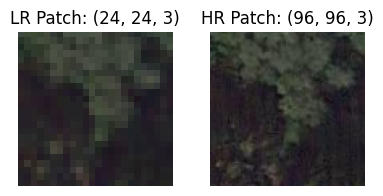

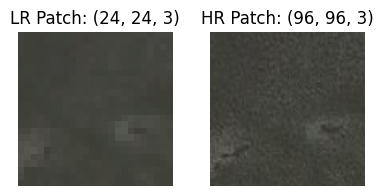

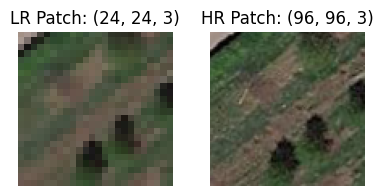

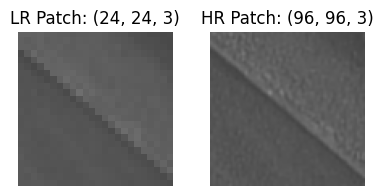

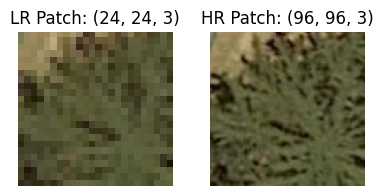

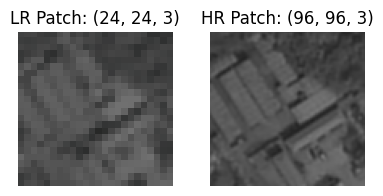

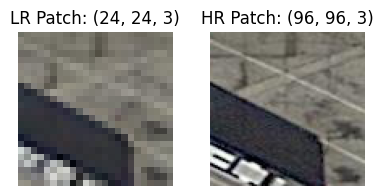

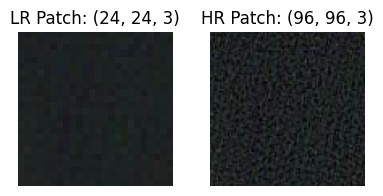

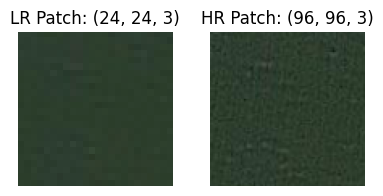

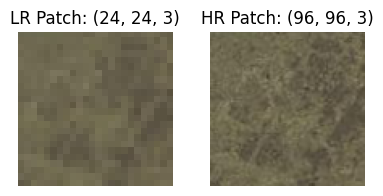

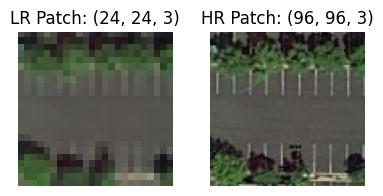

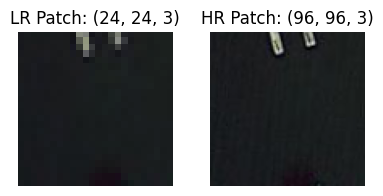

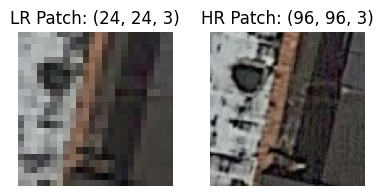

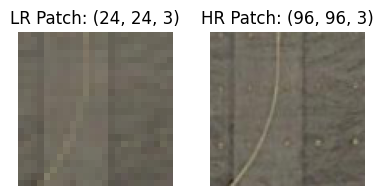

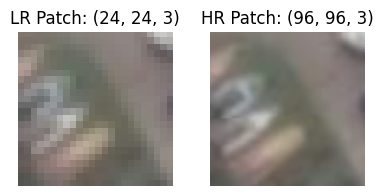

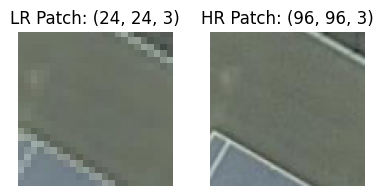

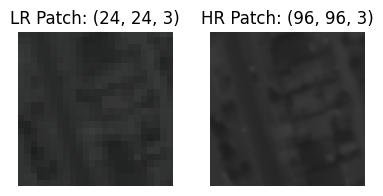

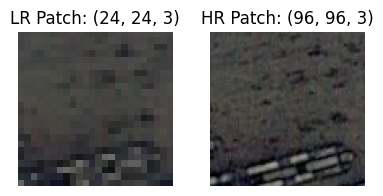

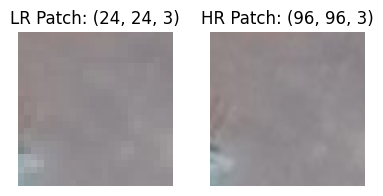

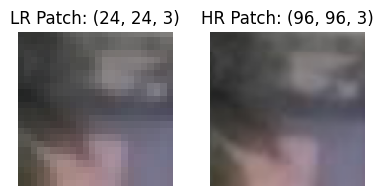

In [6]:
# Visualization function
def visualize_lr_hr(loader, mean, std, num_samples=20):
    """
    Visualizes LR and HR image pairs from the dataloader.

    :param loader: DataLoader object
    :param mean: List of means for denormalization
    :param std: List of standard deviations for denormalization
    :param num_samples: Number of image pairs to visualize
    """
    # Fetch a single batch of data
    data_iter = iter(loader)
    for _ in range(num_samples):
        # Get one batch of images (assuming loader returns a tuple (lr, hr))
        lr_imgs, hr_imgs = next(data_iter)  # Unpack the tuple
        lr_imgs = lr_imgs.cpu()  # Low-resolution images
        hr_imgs = hr_imgs.cpu()  # High-resolution images

        # Denormalize images
        lr_imgs_denorm = denormalize(lr_imgs, mean, std)
        hr_imgs_denorm = denormalize(hr_imgs, mean, std)

        # Plot a random image from the batch
        idx = torch.randint(0, lr_imgs.size(0), (1,)).item()
        lr_img = lr_imgs_denorm[idx].permute(1, 2, 0).numpy()  # Convert to HWC format
        hr_img = hr_imgs_denorm[idx].permute(1, 2, 0).numpy()  # Convert to HWC format

        # Clip values to [0, 1] for imshow
        lr_img = np.clip(lr_img, 0, 1)
        hr_img = np.clip(hr_img, 0, 1)

        # Create a plot
        fig, axes = plt.subplots(1, 2, figsize=(4, 2))
        axes[0].imshow(lr_img)
        axes[0].set_title(f"LR Patch: {lr_img.shape}")
        axes[0].axis("off")

        axes[1].imshow(hr_img)
        axes[1].set_title(f"HR Patch: {hr_img.shape}")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

# Call the visualization function with ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
visualize_lr_hr(train_loader, imagenet_mean, imagenet_std)